In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

## Данные задачи

In [507]:
product_rels = pd.read_pickle('product_rels.pkl')
shop_info = pd.read_pickle('shop_info.pkl')
prices = pd.read_csv('prices.csv')
prices = prices.iloc[:, 2:]

In [508]:
prices

,price_apple,price_banana,price_pear,price_orange,price_lemon
0,90.0,80.0,130.0,100.0,110.0
1,90.0,80.0,130.0,100.0,110.0
2,90.0,80.0,130.0,100.0,110.0
3,90.0,80.0,130.0,100.0,110.0
4,90.0,80.0,130.0,100.0,110.0
...,...,...,...,...,...
155,115.0,80.0,140.0,110.0,120.0
156,115.0,80.0,140.0,110.0,120.0
157,110.0,80.0,135.0,100.0,110.0
158,110.0,80.0,135.0,100.0,110.0


In [509]:
product_rels = pd.DataFrame(product_rels, index=[0])
shop_info = pd.DataFrame(shop_info)
shop_info
shop_info = shop_info.iloc[2:,]

In [510]:
shop_info

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
apple,825.0,618.0,2144.0,727.0,667.0,2067.0,630.0,676.0,671.0,699.0,...,691.0,2226.0,784.0,795.0,859.0,770.0,870.0,668.0,2071.0,588.0
banana,309.0,358.0,1020.0,349.0,272.0,911.0,347.0,272.0,327.0,352.0,...,281.0,1119.0,315.0,301.0,312.0,350.0,409.0,328.0,957.0,381.0
pear,416.0,459.0,1147.0,418.0,409.0,1288.0,394.0,359.0,368.0,367.0,...,378.0,900.0,409.0,451.0,464.0,464.0,459.0,297.0,1325.0,451.0
orange,522.0,460.0,1660.0,556.0,556.0,1366.0,478.0,564.0,464.0,449.0,...,472.0,1412.0,444.0,493.0,534.0,462.0,526.0,499.0,1715.0,529.0
lemon,571.0,657.0,1599.0,437.0,634.0,1750.0,585.0,593.0,658.0,583.0,...,516.0,1593.0,608.0,603.0,615.0,637.0,614.0,616.0,1813.0,537.0


In [479]:
relations = []
fruits = ['apple','banana','pear','orange','lemon']
for fruit in fruits:
    list = product_rels[fruit].values.tolist()[0]
    relations.append(list)
print(relations)

[[0.0, 0.15, -0.15, 0.17, 0.17], [0.15, 0.0, 0.12, 0.1, 0.1], [-0.15, 0.12, 0.0, 0.12, 0.12], [0.17, 0.1, 0.12, 0.0, -0.19], [0.17, 0.1, 0.12, -0.19, 0.0]]


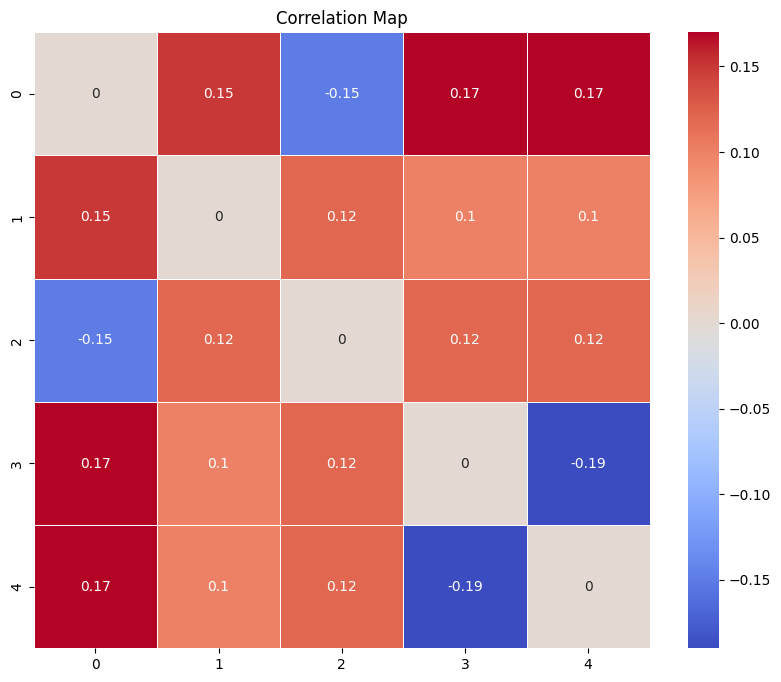

In [515]:
plt.figure(figsize=(10, 8))
sns.heatmap(relations, annot=True, cmap='coolwarm', square=True, linewidths=.5)
plt.title('Correlation Map')
plt.show()

In [517]:
prices = prices.rename(columns={'price_apple': 'apple', 'price_banana' : 'banana', 'price_pear' : 'pear', 'price_orange' : 'orange', 'price_lemon' : 'lemon'})

## Модель прогноза продаж

### Используем pyomo и солвер ipopt

In [471]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

### Переменные задачи

In [460]:
S = shop_info.T.shape[0] 
W = prices.shape[0] 
P = 5 
M = shop_info.T.values 
C = relations 
r_seas = prices.values.T

In [461]:
model = ConcreteModel()
model.p = RangeSet(0, P)
model.w = RangeSet(0, W)
model.s = RangeSet(0, S)
model.r = Var(model.p, model.w, domain=NonNegativeReals)

### Ограничения

In [524]:
model.constraints = ConstraintList()
for p in range(P):
    for w in range(W):
        model.constraints.add(model.r[p, w] >= 0.75 * r_seas[p, w])
        model.constraints.add(model.r[p, w] <= 1.25 * r_seas[p, w])

'pyomo.core.base.constraint.ConstraintList'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.constraint.ConstraintList'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().


### Ожидаемая выручка в зависимости от цены за период прогнозирования W 

In [503]:
def F(model):
    return sum(sum(sum(model.r[p,w] * (M[s,p] * (-(model.r[p,w] / r_seas[p,w]) ** 2 
                - 0.075 * model.r[p,w] / r_seas[p,w] + 2.85) / 1.775
             + sum((r_seas[o,w]/model.r[o,w])**2 * C[p][o] * M[s,o] for o in range(P)))
                       for w in range(W)) for p in range(P)) for s in range(S))

### Решение

In [520]:
model.obj = Objective(rule=F, sense=maximize)
solver = SolverFactory('ipopt')
results = solver.solve(model)
print(results)

'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().

Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1600
  Number of variables: 800
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 2.871913433074951
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [523]:
objective_value = model.obj()
print("Ожидаемая выручка с оптимизацией:", objective_value)

Ожидаемая выручка с оптимизацией: 5155170216.513078


Получим оптимальное r

In [699]:
optimal_prices = np.zeros((P, W))
for p in range(P):
    for w in range(W):
        optimal_prices[p, w] = model.r[p, w].value

### График выручки по неделям

In [635]:
def F_calc(r: list) -> list:
    S = shop_info.T.shape[0]
    W = prices.shape[0]
    P = 5
    M = shop_info.T.values
    C = relations
    r_seas = prices.values.T

    return [sum(sum(r[p][w] * (M[s,p] * ((-(r[p][w] / r_seas[p,w]) ** 2 
                - 0.075 * (r[p][w] / r_seas[p,w]) + 2.85) / 1.775)
             + sum((r_seas[o,w]/r[o][w])**(2) * C[p][o] * M[s,o] for o in range(P)))
                       for p in range(P)) for s in range(S)) for w in range(W)]    

In [636]:
def generate_prices(mode):
    W = prices.shape[0] 
    P = 5 
    M = shop_info.T.values  
    r_seas = prices.values.T
    if (mode == 'min'):
        return [[0.75*r_seas[p,w] for w in range(W)] for p in range(P)]
    elif(mode == 'max'):
        return [[1.25*r_seas[p,w] for w in range(W)] for p in range(P)]   
    elif(mode == 'random'):
        return [[random.uniform(0.75*r_seas[p,w], 1.25*r_seas[p,w]) for w in range(W)] for p in range(P)]      
    elif (mode == 'seasonal'):
        return r_seas
    else:
        raise ValueError("Invalid mode specified.")

In [707]:
weeks = np.arange(0, 25) 
y_min = generate_prices('min')
y_max = generate_prices('max')
y_rand = generate_prices('random')
y_seas = generate_prices('seasonal')

revenue_min = F_calc(y_min)[0:25]
revenue_max = F_calc(y_max)[0:25]
revenue_rand = F_calc(y_rand)[0:25]
revenue_seas = F_calc(y_seas)[0:25]
revenue_opt = F_calc(optimal_prices)[0:25]

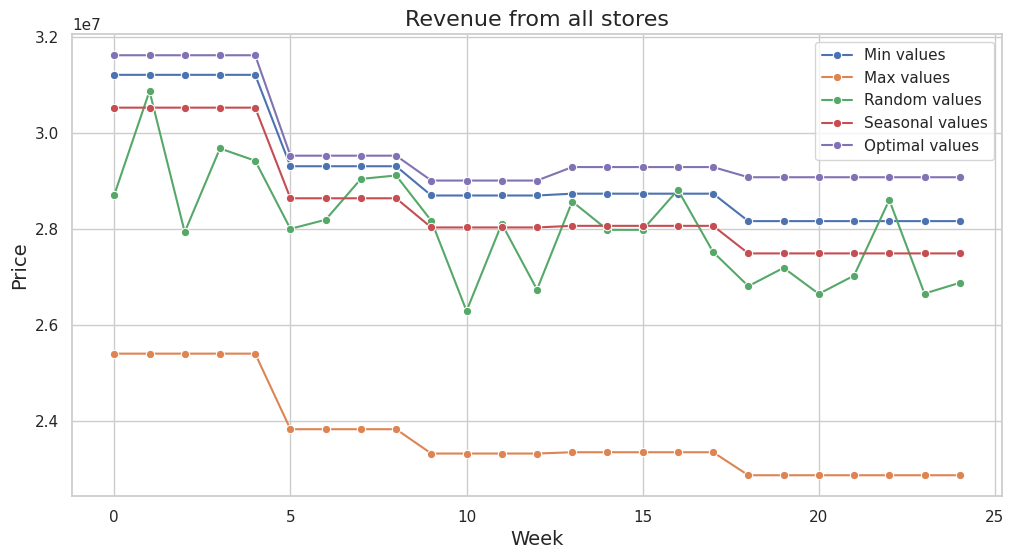

<Figure size 640x480 with 0 Axes>

In [711]:
data_melted = pd.DataFrame({
    'Week': np.tile(weeks, 5),
    'Price': np.concatenate([revenue_min, revenue_max, revenue_rand, revenue_seas, revenue_opt]),
    'Price Type': ['Min values'] * len(weeks) + ['Max values'] * len(weeks) + ['Random values'] * len(weeks) + ['Seasonal values'] * len(weeks)
    + ['Optimal values'] * len(weeks)
})

sns.set(style="whitegrid")  
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_melted, x='Week', y='Price', hue='Price Type', marker='o')

plt.title('Revenue from all stores', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend()
plt.show()
plt.savefig('revenue')